In [334]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# GDP data reading and cleaning

In [2]:
gdp_path = '../../data/expenditure/expenditure_gdp.csv'
gdp = pd.read_csv(gdp_path)
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])
gdp.head(2)

C:\Users\sidhu\AppData\Local\Temp/ipykernel_452/2999133702.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gdp = pd.read_csv(gdp_path)


,REF_DATE,GEO,DGUID,Prices,Seasonal adjustment,Estimates,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Final consumption expenditure,Dollars,81,millions,6,v62305723,1.1.1.1,273818.0,NaN,NaN,NaN,0
1,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Household final consumption expenditure,Dollars,81,millions,6,v62305724,1.1.1.2,182300.0,NaN,NaN,NaN,0


### Extracted only required columns and rows

In [3]:
# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})
gdpts.index = gdpts['Date']
gdpts = gdpts.drop(columns = ['Date'])

In [4]:
gdpts.head()

,GDP
Date,
2004-01-01,1566737.0
2004-04-01,1585347.0
2004-07-01,1604061.0
2004-10-01,1615585.0
2005-01-01,1621176.0


### Time series of GDP

In [274]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

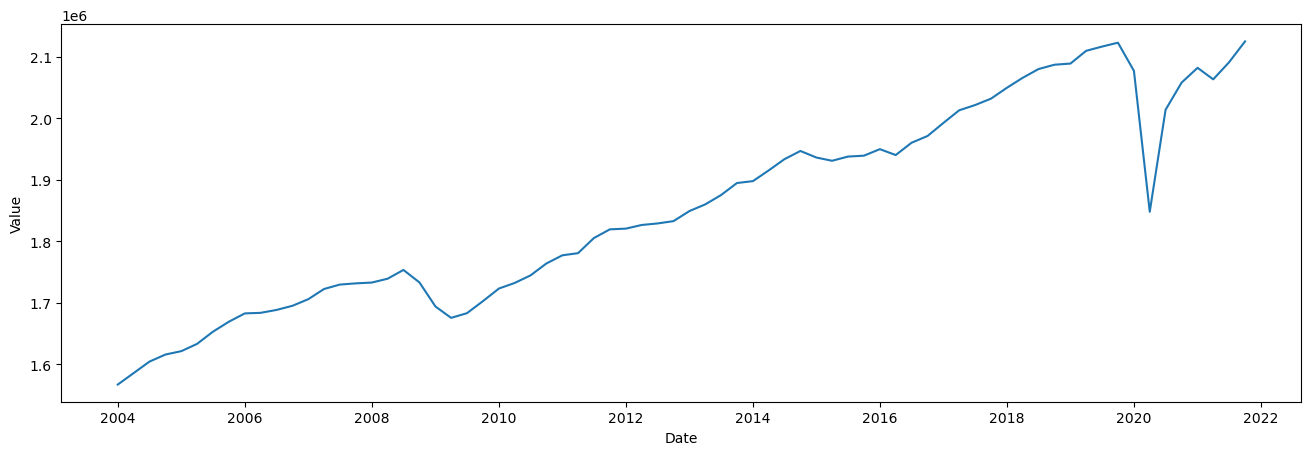

In [271]:
plot_df(gdp_data['GDP'])

### Growth rate of GDP

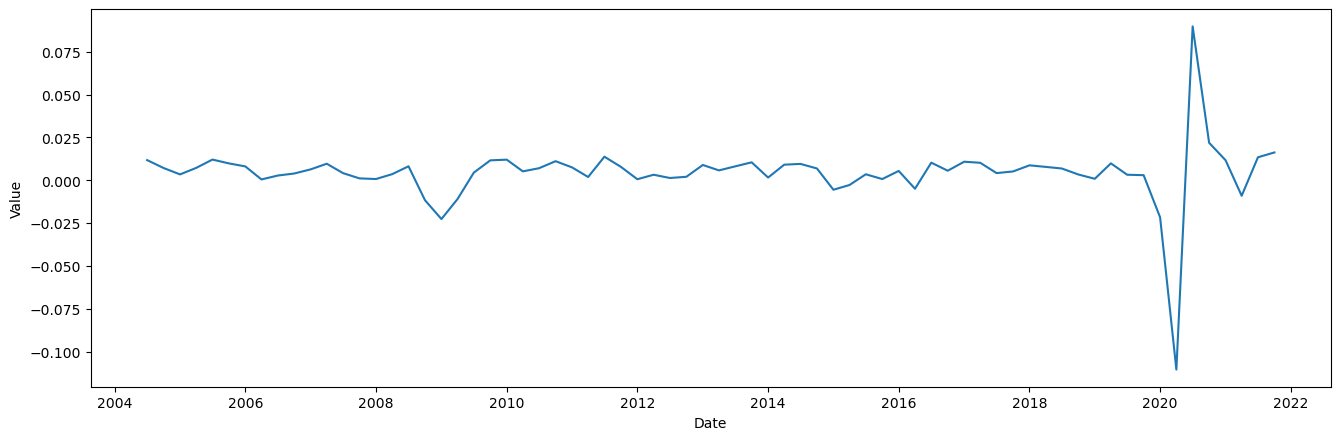

In [244]:
gdpts['GDP_GrowthRate'] = gdpts['GDP'].pct_change()
gdpts = gdpts.dropna()

plot_df(gdpts['GDP_GrowthRate'])

### Check stationarity

In [405]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"

def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

In [8]:
adf_test(gdpts['GDP_GrowthRate'])


Series is stationary


In [9]:
kstest = kpss_test(gdpts['GDP_GrowthRate'])

Series is stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Get predictors from Google Trends

In [10]:
# get caegories and keywords from csv file
key_path = '../../data/keywords_data/GDP.csv'
key_data = pd.read_csv(key_path)
cat_lst = key_data['CatNo'].unique()                    # list of categories
keywords_lst = key_data['Keywords'].dropna()   # list of selected keywords
keyCat_lst = key_data['keywordCatNo'].astype('Int64').dropna()   # list of categories corresponding to keywords

#### function to get trends using keyword/category

In [86]:
pytrends = TrendReq(hl='en-US', backoff_factor=0.1, timeout=(10,25))

# function to get google trend time series of respective


def get_trends(keyword=[''], category='0', related_queries=0, related_topics=0):
    """ function to get the google trend for desired keyword and category"""
    kw_list = keyword
    cat = category
    timeframe = '2004-01-01 2022-04-01'
    geo = 'CA'
    gprop = ''

    try:
        pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
        # get time series
        data = pytrends.interest_over_time()
    except:
        print(f"Category {cat} does not exist or keyword {kw_list[0]} has no time series")
        return [''], [''], ['']

    # get related queries
    try:
        if related_queries > 0:
            queries = pytrends.related_queries()
            if len(kw_list) == 0:
                queries_lst = list(queries['']['top']['query'].values[0:related_queries])
            else:
                queries_lst = list(queries[kw_list[0]]['top']['query'].values[0:related_queries])
        else:
            queries_lst = ['']
    except:
        queries_lst = ['']

    # get related topics
    try:
        if related_topics > 0:
            topics = pytrends.related_topics()
            if len(kw_list) == 0:
                topics_lst = list(topics['']['top']['topic_title'].values[0:related_topics])
            else:
                topics_lst = list(topics[kw_list[0]]['top']['topic_title'].values[0:related_topics])
        else:
            topics_lst = ['']
    except:
        topics_lst = ['']
    return data, queries_lst, topics_lst

#### function to get trends using keyword and respective category from a dictionary

In [64]:
# get timeseries dataframe of related queries and topics (top 2) of different selected categories
def get_trends_for_dict(dict, no_related_words):
    i = 0
    for key, value in dict.items():
        if no_related_words > len(value):
            print("Number of related words should not exceed {len(value)}.")
        else:
            category = key
            temp_lst = value[0:no_related_words]  # how may related words we want data for
            kw_lst = list(set(temp_lst))                # removes the repeated keywords
            for keyword in kw_lst:
                data, _, _ = get_trends(keyword=[keyword], category=category)
                time.sleep(5)
                # Code to append data for different keywords in data frame
                colname = category+"_"+keyword
                if data[0] == '':
                    continue
                else:
                    if i == 0:
                        data.rename(columns={keyword: colname}, inplace=True)
                        df = data.drop(columns=['isPartial'])
                    else:
                        data.rename(columns={keyword: colname}, inplace=True)
                        data = data.drop(columns=['isPartial'])
                        df = df.join(data)
                i = i+1
    return df

In [27]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

# get time series and related queries and topics of categories
for i, category in enumerate(cat_lst):
    category = str(category)
    data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
    cat_queries_dict[category] = queries
    cat_topics_dict[category] = topics

    # Code to append data for different columns in data frame
    if i == 0:
        data.rename(columns={'': category}, inplace=True)
        categoryts = data.drop(columns=['isPartial'])
    else:
        data.rename(columns={'': category}, inplace=True)
        data = data.drop(columns=['isPartial'])
        categoryts = categoryts.join(data)

In [ ]:
# get dataframe of timeseries for keywords

keywords_queries_dict = {}
keywords_topics_dict = {}

# get time series and related queries and topics of selected keywords
for i, keyword in enumerate(keywords_lst):
    category = str(keyCat_lst[i])
    data, queries, topics = get_trends(keyword=[keyword], category=category, related_queries=2, related_topics=2)
    keywords_queries_dict[category] = queries
    keywords_topics_dict[category] = topics
    

    # Code to append data for different columns in data frame
    if i == 0:
        keywordsts = data.drop(columns=['isPartial'])
    else:
        data = data.drop(columns=['isPartial'])
        keywordsts = keywordsts.join(data)

In [12]:
# Read data from dictionaries
file1 = open('gdp_cat_queries_dict.json')
file2 = open('gdp_cat_topics_dict.json')

cat_queries_dict = json.load(file1)
cat_topics_dict = json.load(file2)

In [144]:
cat_topics_dict
temp = {'569': ['Cineplex Entertainment', 'Film']}

In [145]:
df1 = get_trends_for_dict(temp, no_related_words=2)
df1.head()

Category 569 does not exist or keyword Cineplex Entertainment has no time series
Category 569 does not exist or keyword Film has no time series


UnboundLocalError: local variable 'df' referenced before assignment

In [28]:
#df1.to_csv('data_fo_related_queries.csv')

In [92]:
relatedQ_df = pd.read_csv('data_fo_related_queries.csv', index_col=0)

In [17]:
df2 = get_trends_for_dict(cat_topics_dict, no_related_words=1)
df2.head()

,569_Cineplex Entertainment,23_Dance,47_Car,815_Canada,170_Driving,249_Health,71_Recipe,276_Restaurant,634_Clinic,250_Hospital,...,1162_Canada Revenue Agency,53_GoDaddy,342_Enterprise resource planning,1159_Salary,1214_Truck,670_Fertilizer,12_Canada,566_Textile,672_Adhesive,673_Color
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,75,83,74,53,67,28,36,14,65,...,0,4,0,22,45,24,53,60,10,50
2004-02-01,0,71,84,80,44,54,26,35,11,76,...,0,5,100,29,53,31,51,100,41,76
2004-03-01,0,82,87,89,46,62,24,34,10,78,...,0,1,0,23,41,61,51,48,13,31
2004-04-01,19,79,95,85,52,51,23,31,12,79,...,0,3,0,40,53,31,51,71,61,100
2004-05-01,0,76,100,92,49,76,24,33,12,73,...,0,4,0,27,58,27,49,43,45,0


In [22]:
df2.to_csv('data_of_related_topics.csv')

In [89]:
relatedT_df = pd.read_csv('data_of_related_topics.csv', index_col=0)

### Store data

In [534]:
keywordsts.to_csv('gdp_keywords_ts.csv')
categoryts.to_csv('gdp_category_ts.csv')

#store Queries and topics
with open('gdp_cat_queries_dict.json', 'w') as fp:
    json.dump(cat_queries_dict, fp,  indent=4)

with open('gdp_cat_topics_dict.json', 'w') as fp:
    json.dump(cat_topics_dict, fp,  indent=4)
    
with open('gdp_keywords_queries_dict.json', 'w') as fp:
    json.dump(keywords_queries_dict, fp,  indent=4)

with open('gdp_keywords_topics_dict.json', 'w') as fp:
    json.dump(keywords_topics_dict, fp,  indent=4)

In [18]:
keywordsts.to_csv('gdp_keywords_ts_1205.csv')
categoryts.to_csv('gdp_category_ts_1205.csv')

### Read data

In [90]:
keywordsts = pd.read_csv('gdp_keywords_ts.csv', index_col=0)
categoryts = pd.read_csv('gdp_category_ts.csv', index_col=0)

# data on 12-05-2022
categoryts_today = pd.read_csv('gdp_category_ts_1205.csv', index_col=0)

### Check for two samples at different time

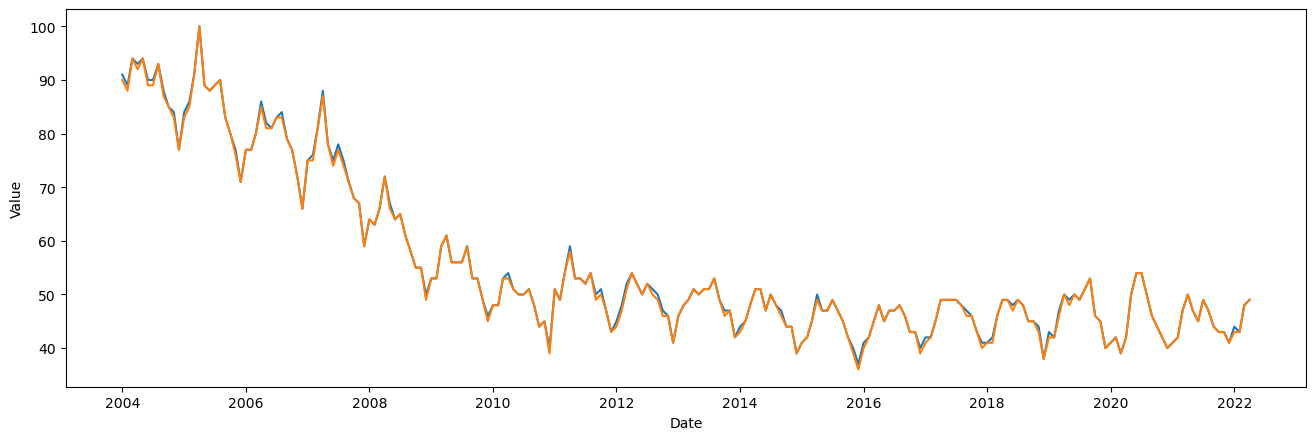

In [245]:
temp = pd.DataFrame({'A':categoryts[categoryts.columns[2:3]]['47'], 'B':categoryts_today[categoryts_today.columns[2:3]]['47']})
plot_df(temp[temp.columns[0:5]])

# Remove long-term bias (downward trend)

### Functions to extract long term trend and remove long term bias

In [410]:
# function to get long term trend
# source link: statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data

In [411]:
transformed_data = remove_downward_trend_bias(categoryts, categoryts)

In [94]:
all_keywords_df = keywordsts.join(relatedQ_df)
all_keywords_df.head()

,Economic crisis,Crisis,Recession,Financial crisis,Krach,Unemployment,Unemployment benefits,Student loan,Loan,Interest,...,12_acces d,12_canada post,566_fabric,566_fabric fabric,672_epoxy,672_glue,673_couleurs,673_couleur,49_covid,49_manufacturing
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,27,0,0,0,27,25,43,55,44,...,7,22,34,35,13,10,63,20,0,83
2004-02-01,0,0,0,0,36,23,5,53,46,46,...,6,21,41,41,19,5,65,9,0,100
2004-03-01,0,0,0,0,44,20,32,34,42,45,...,7,19,59,59,23,12,62,36,0,58
2004-04-01,0,27,50,100,0,22,10,43,55,56,...,7,19,43,43,29,12,56,23,0,80
2004-05-01,0,0,45,0,0,17,14,41,50,49,...,9,19,35,35,16,11,44,31,0,73


In [99]:
categoryts.head()

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-02-01,70,85,89,93,88,87,72,58,52,98,...,96,100,95,91,77,99,96,79,82,100
2004-03-01,74,82,94,98,87,89,73,61,53,100,...,99,98,99,94,100,95,100,82,100,97
2004-04-01,72,82,93,96,89,83,70,55,54,94,...,89,92,89,98,96,94,87,77,81,89
2004-05-01,74,81,94,96,97,92,66,53,49,94,...,89,90,84,90,86,88,93,76,64,80


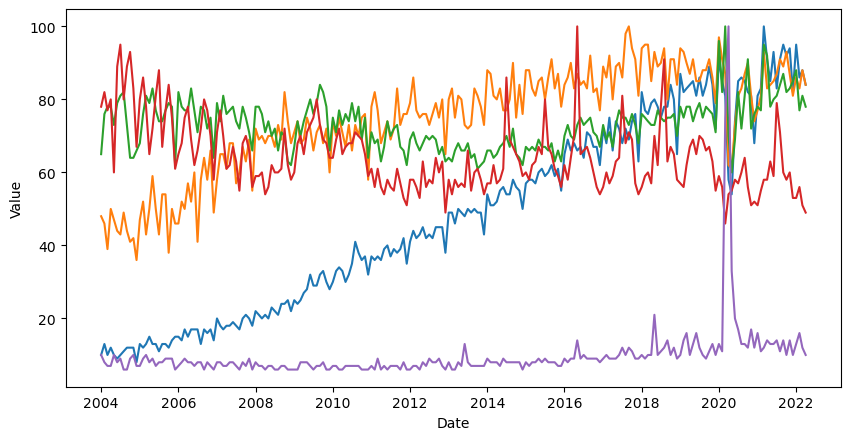

In [273]:
plot_df(all_keywords_df[all_keywords_df.columns[40:45]], width = 10)

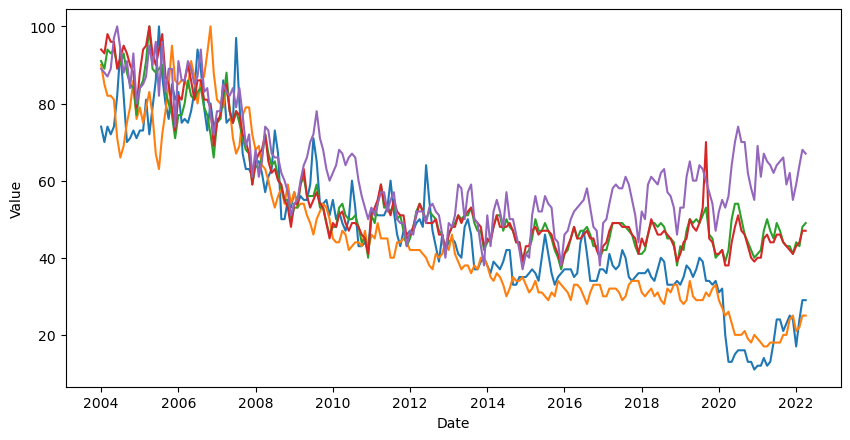

In [275]:
plot_df(categoryts[categoryts.columns[0:5]], width=10)

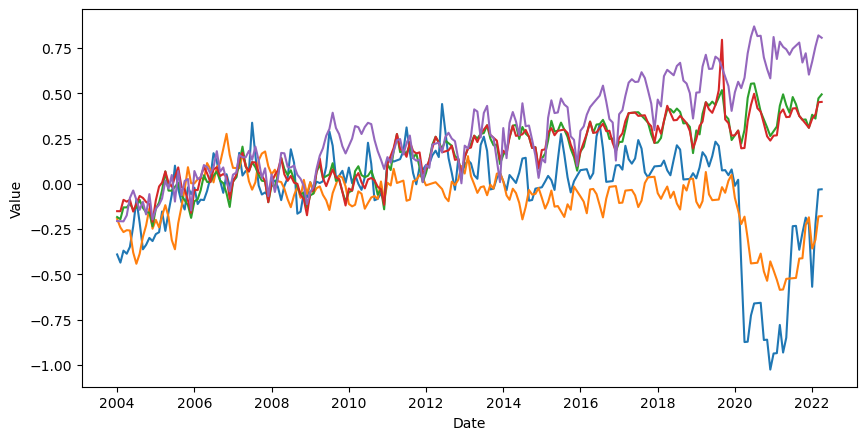

In [281]:
plot_df(transformed_data[transformed_data.columns[0:5]], width=10)

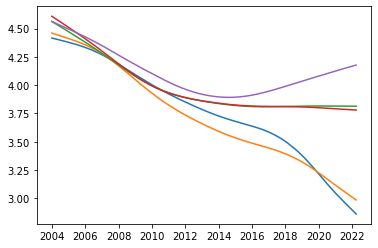

In [420]:
plt.plot(longtrend_data[longtrend_data.columns[0:5]])
plt.show()

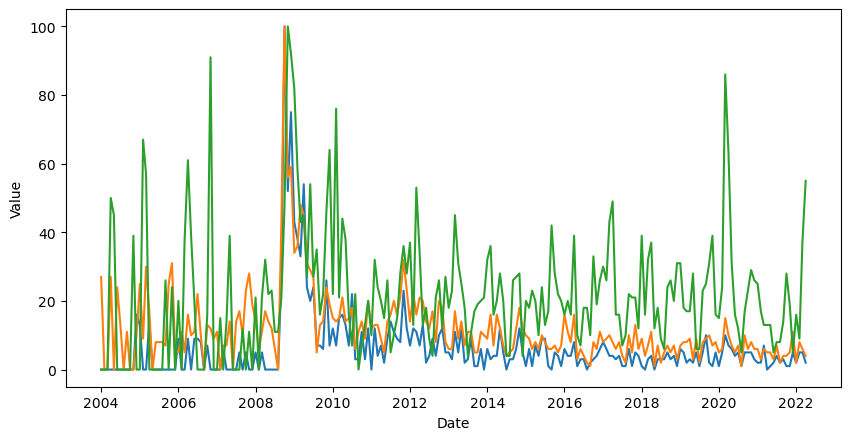

In [284]:
keywordsts.index = pd.to_datetime(keywordsts.index)
plot_df(keywordsts[keywordsts.columns[0:3]], width = 10)

# Make GDP data quarterly

In [213]:
def get_gdp_data_quarterly(dataframe, match='0'):
    """ provides quarterly data of gdp predictors when monthly data is passed 
    input arguments: 
    dataframe: monthly data of google trends
    match: can take values '0', '-1', '-2', '-01', '-12', '-012'
           if match = 0 then data of months 1, 4, 7, 10 is returned that is same month when GDP is published
           if match = -1 then data (Google Trends) of one previous month 12, 3, 6, 9 are returned 
           if match = -2 then data (Google Trends) of one previous month 11, 2, 5, 8 are returned
           if match = -01 then data of same and previous month data is returned
           if match = -12 then data of two previous months is returned
           if match = -012 then data of all three months is returned"""
    if match not in ['0', '-1', '-2', '-01', '-12', '-012']:
        raise ValueError("Incorrect match value is passed !!")

    try:
        dataframe.index = pd.to_datetime(dataframe.index)

        same_month_data = dataframe[(dataframe.index.month == 4) |
                                    (dataframe.index.month == 7) |
                                    (dataframe.index.month == 10) |
                                    (dataframe.index.month == 1)]

        one_month_back_data = dataframe[(dataframe.index.month == 3) |
                                        (dataframe.index.month == 6) |
                                        (dataframe.index.month == 9) |
                                        (dataframe.index.month == 12)]
        one_month_back_data.index = one_month_back_data.index + pd.DateOffset(months=1)

        two_months_back_data = dataframe[(dataframe.index.month == 2) |
                                        (dataframe.index.month == 5) |
                                        (dataframe.index.month == 8) |
                                        (dataframe.index.month == 11)]
        two_months_back_data.index = two_months_back_data.index + pd.DateOffset(months=2)

        if str(match) == '0':
            return same_month_data
        if str(match) == '-1':
            return one_month_back_data
        if str(match) == '-2':
            return two_months_back_data
        if str(match) == '-01':
            return pd.merge(same_month_data, one_month_back_data, left_index=True, right_index=True)
        if str(match) == '-12':
            return pd.merge(one_month_back_data, two_months_back_data, left_index=True, right_index=True)
        if str(match) == '-012':
            temp = pd.merge(same_month_data, one_month_back_data, left_index=True, right_index=True)
            return pd.merge(temp, two_months_back_data, left_index=True, right_index=True)
    except:
        print("Incorrect dataframe is passed !!")

In [313]:
Qcatgory_df = get_gdp_data_quarterly(categoryts, match = '0')
Qallkeywords_df = get_gdp_data_quarterly(all_keywords_df, match = '0')

In [314]:
Qcatgory_df.head()

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-04-01,72,82,93,96,89,83,70,55,54,94,...,89,92,89,98,96,94,87,77,81,89
2004-07-01,94,66,90,92,94,86,65,53,57,89,...,89,87,77,80,71,81,74,80,59,74
2004-10-01,71,79,85,90,84,81,76,54,57,89,...,79,88,86,77,79,89,92,80,89,92
2005-01-01,73,79,84,88,84,90,75,63,65,93,...,86,86,92,79,70,89,91,74,79,80


In [315]:

Qallkeywords_df.head()

,Economic crisis,Crisis,Recession,Financial crisis,Krach,Unemployment,Unemployment benefits,Student loan,Loan,Interest,...,12_acces d,12_canada post,566_fabric,566_fabric fabric,672_epoxy,672_glue,673_couleurs,673_couleur,49_covid,49_manufacturing
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,27,0,0,0,27,25,43,55,44,...,7,22,34,35,13,10,63,20,0,83
2004-04-01,0,27,50,100,0,22,10,43,55,56,...,7,19,43,43,29,12,56,23,0,80
2004-07-01,0,13,0,0,0,26,20,85,62,41,...,9,19,42,41,23,6,48,17,0,70
2004-10-01,0,0,0,0,55,18,12,58,53,39,...,9,18,46,46,19,6,100,37,0,61
2005-01-01,13,25,0,0,22,22,16,32,43,44,...,8,24,47,47,17,11,52,29,0,73


In [232]:
gdpts.head()

,GDP,GDP_GrowthRate
Date,,
2004-04-01,1585347.0,0.011878
2004-07-01,1604061.0,0.011804
2004-10-01,1615585.0,0.007184
2005-01-01,1621176.0,0.003461
2005-04-01,1632938.0,0.007255


# Make series stationary

In [442]:
# function to normalize data

def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# function to get first difference (detrending)
def detrend(dataframe):
    return dataframe.diff().dropna()


# funtion to remove seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data


# funtion to remove volatility
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [317]:
scaled_Qcategory = normalize(Qcatgory_df)
scaled_Qkeywords = normalize(Qallkeywords_df)

In [377]:
firstdiff_Qcategory = detrend(scaled_Qcategory)
firstdiff_Qkeywords = detrend(scaled_Qkeywords)

In [376]:
final_category_df = remove_seasonality(firstdiff_Qcategory)

In [451]:
temp = remove_downward_trend_bias(Qcatgory_df, Qcatgory_df, freq = 'Q')
temp1 = normalize(temp)
temp2 = detrend(detrend(temp1))
temp3 = remove_seasonality(temp2)

In [455]:
check_stationarity(detrend(firstdiff_Qkeywords))

c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 71_pizza is not stationary, differencing can be used to make it stationary
Series 634_clinic is trend stationary, trend needs to be removed


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 287_valve is not stationary, differencing can be used to make it stationary
Series 612_car wash is trend stationary, trend needs to be removed


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 1199_ordre is not stationary, differencing can be used to make it stationary
Series 255_clinique médicale is not stationary, differencing can be used to make it stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 289_trucks is not stationary, differencing can be used to make it stationary
Series 665_traversier is not stationary, differencing can be used to make it stationary
Series 662_air france is trend stationary, trend needs to be removed


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 650_portail is trend stationary, trend needs to be removed
Series 651_bridge is not stationary, differencing can be used to make it stationary
Series 652_contractors is not stationary, differencing can be used to make it stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 208_niagara falls is trend stationary, trend needs to be removed
Series 610_ford is not stationary, differencing can be used to make it stationary
Series 918_pizza pizza is not stationary, differencing can be used to make it stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 918_pizza is not stationary, differencing can be used to make it stationary
Series 465_home insurance is trend stationary, trend needs to be removed


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 784_dow is not stationary, differencing can be used to make it stationary
Series 832_carpet is not stationary, differencing can be used to make it stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 278_tax is not stationary, differencing can be used to make it stationary
Series 314_avg is trend stationary, trend needs to be removed


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

Series 342_dashboard is not stationary, differencing can be used to make it stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is g

All other series are stationary


c:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


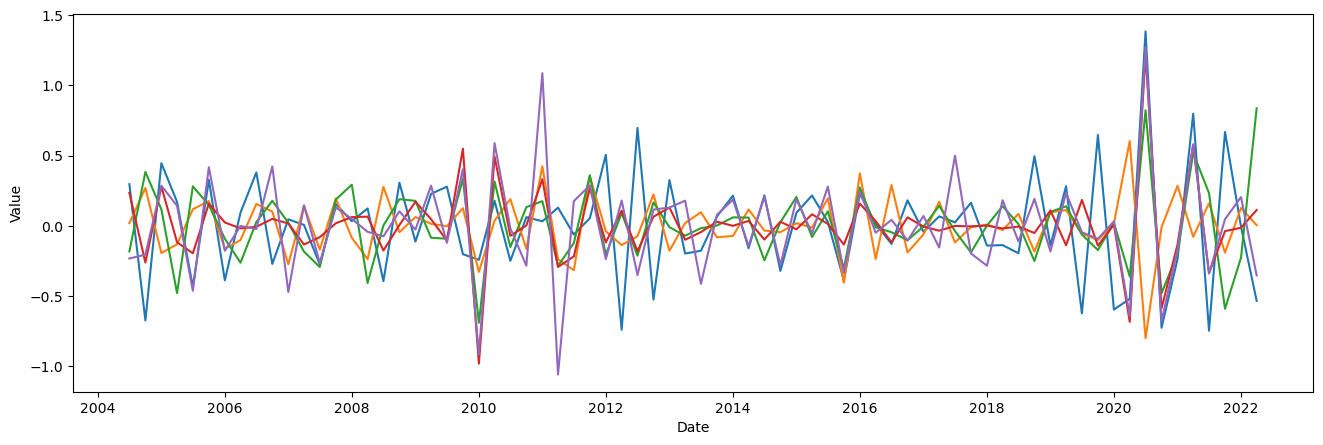

In [453]:
plot_df(temp3[temp3.columns[5:10]])

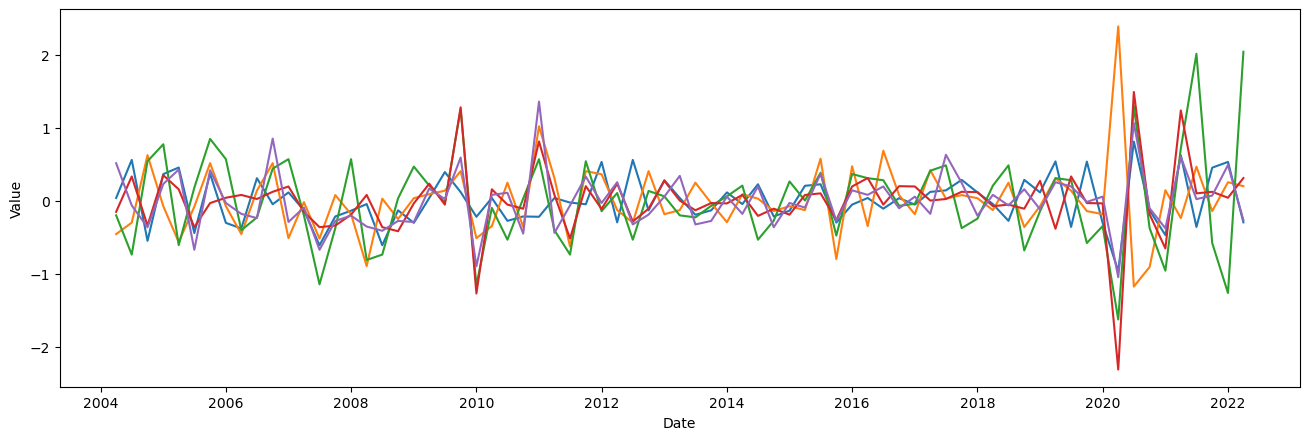

In [423]:
plot_df(final_category_df[final_category_df.columns[5:10]])

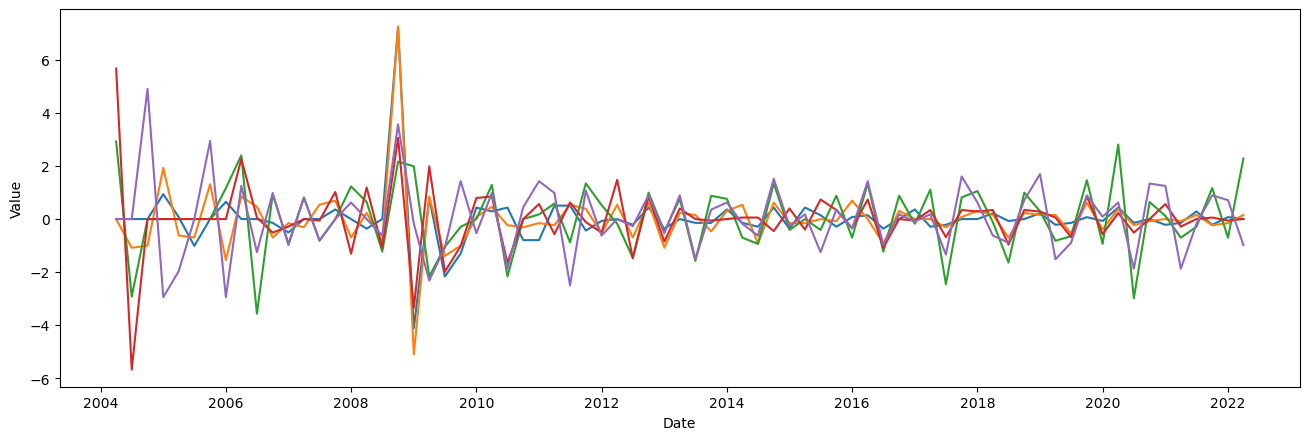

In [457]:
plot_df(firstdiff_Qkeywords[firstdiff_Qkeywords.columns[0:5]])

### Plot trends

In [12]:
pytrends.suggestions("Economic crisis")

[{'mid': '/g/1211cg58', 'title': 'economic crisis', 'type': 'Topic'},
 {'mid': '/g/11q2xlm4ss',
  'title': '2019–present Sri Lankan economic crisis',
  'type': 'Event'},
 {'mid': '/m/080pqzt',
  'title': '1998–1999 Ecuador economic crisis',
  'type': 'Topic'},
 {'mid': '/g/11bwdr23n9',
  'title': '2013–present economic crisis in Venezuela',
  'type': 'Topic'},
 {'mid': '/m/05p85kd',
  'title': '1991 Indian economic crisis',
  'type': 'Topic'}]